It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
<table align="center">
 <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ezponda/intro_deep_learning/blob/main/class/RNN/IMBD_RNN.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/ezponda/intro_deep_learning/blob/main/class/RNN/IMBD_RNN.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# Classification Example
 Two-class classification, or binary classification, may be the most widely applied kind of machine-learning problem. In this example, you’ll learn to classify movie reviews as positive or negative, based on the text content of the reviews.


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def show_loss_accuracy_evolution(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Sparse Categorical Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train Error')
    ax1.plot(hist['epoch'], hist['val_loss'], label='Val Error')
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    ax2.plot(hist['epoch'], hist['val_accuracy'], label='Val Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()

## The Dataset: The IMDB dataset
We’ll work with the IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database. They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews. The  parameter `num_words` controls how many words different we want to use.

In [2]:
from tensorflow.keras.datasets import imdb
num_words = 10000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)
print(train_data[0])

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/aezponda/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/aezponda/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shape

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [3]:
# Transform word_id to word and reverse
word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3

For transforming an id-sequence to a phrase use get_words

In [4]:
def get_words(sentence, int2word):
    return ' '.join([int2word.get(i, '<UNK>') for i in sentence])


get_words(train_data[0], int2word)

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

# MLP model

## Data Preprocessing

You need to convert your raw text to an appropriate input to a sequential model 

In [5]:
def vectorize_text_sentence(text, word2int):
    tokens = text.split(' ')
    tokens_id = [word2int.get(tk,2) for tk in tokens]
    return tokens_id

text = get_words(train_data[0], int2word)
print(text)
print(vectorize_text_sentence(text, word2int))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

We are going to use a bag of words model. BoW is a simplifying representation used in natural language processing. In this model, a text (such as a sentence or a document) is represented as the Each key is the word, and each value is the frequency of occurrences of that word in the given text document.

- **Input document**: `"John likes to watch movies Mary likes movies too"`
- **BoW**: `{'John': 0.11, 'likes': 0.22, 'to': 0.11, 'watch': 0.11, 'movies': 0.22, 'Mary': 0.11, 'too': 0.11}`


In [6]:
from collections import Counter


def get_bag_of_words(sequence, norm=True):
    word_count = Counter(sequence)
    if norm:
        total = sum(word_count.values())
        word_freq = {w: n / total for w, n in word_count.items()}
        return word_freq
    else:
        return dict(word_count.items())


text_example = "John likes to watch movies Mary likes movies too"
print('text_example', text_example)
text_sequence = text_example.split()
print('text splitted', text_sequence)
bag_of_words = get_bag_of_words(text_sequence)
print('bag_of_words', bag_of_words)
print('bag_of_words norm=False', get_bag_of_words(text_sequence, norm=False))
print(
    'bag_of_words with indexes', {
        word2int[w.lower()]: p
        for w, p in get_bag_of_words(text_sequence, norm=False).items()
    })

text_example John likes to watch movies Mary likes movies too
text splitted ['John', 'likes', 'to', 'watch', 'movies', 'Mary', 'likes', 'movies', 'too']
bag_of_words {'John': 0.1111111111111111, 'likes': 0.2222222222222222, 'to': 0.1111111111111111, 'watch': 0.1111111111111111, 'movies': 0.2222222222222222, 'Mary': 0.1111111111111111, 'too': 0.1111111111111111}
bag_of_words norm=False {'John': 1, 'likes': 2, 'to': 1, 'watch': 1, 'movies': 2, 'Mary': 1, 'too': 1}
bag_of_words with indexes {308: 1, 1232: 2, 8: 1, 106: 1, 102: 2, 1083: 1, 99: 1}


After that, we convert every BoW to a vector of `dim=num_words` with `vectorize_sequences`

In [7]:
def vectorize_sequence(sequence, num_words, norm=True):
    vec = np.zeros(num_words)
    bow = get_bag_of_words(sequence, norm)
    for w, freq in bow.items():
        if w < num_words:
            vec[w] = freq
    return vec


def vectorize_sequences(sequences, num_words=num_words, norm=True):
    """Creates an all-zero matrix of shape (len(sequences), num_words)"""
    results = np.zeros((len(sequences), num_words))
    for i, sequence in enumerate(sequences):
        results[i, :] = vectorize_sequence(sequence, num_words, norm)
    return results


x_train = vectorize_sequences(train_data, num_words=num_words)
x_test = vectorize_sequences(test_data, num_words=num_words)
y_train =np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
x_train.shape, y_train.shape

((25000, 10003), (25000,))

## Define and train a model 
Define, compile and fit your sequential model

In [ ]:
model = ...
history = model.fit(x_train, y_train, validation_split=0.2, ...)

In [ ]:
show_loss_accuracy_evolution(history)

### Evaluate the model
You need to obtain a Test Accuracy > 0.85. Try to get more than 0.9!

In [ ]:
results = model.evaluate(x_test, y_test, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

### Making predictioins with new data

In [ ]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant']
sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

x_pred = vectorize_sequences(sequences, num_words=num_words)
np.round(model.predict(x_pred), 4)

# RNN model

Lets use a recurrent neural network and compare results


### Simple RNN model

There are three built-in RNN layers in Keras:

1. [`keras.layers.SimpleRNN`](https://keras.io/api/layers/recurrent_layers/simple_rnn/), a fully-connected RNN where the output from previous
timestep is to be fed to next timestep.

```python
tf.keras.layers.SimpleRNN(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````

2. [`keras.layers.GRU`](https://keras.io/api/layers/recurrent_layers/gru/), first proposed in
[Cho et al., 2014](https://arxiv.org/abs/1406.1078).
```python
tf.keras.layers.GRU(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
```

3. [`keras.layers.LSTM`](https://keras.io/api/layers/recurrent_layers/lstm/), first proposed in
[Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf).
```python
tf.keras.layers.LSTM(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````
For more information, see the
[RNN API documentation](https://keras.io/api/layers/recurrent_layers/).





In sequence classification we are going to use the **many-to-one** architecture with default parameter `return_sequences=False`.

The shape of the output  for this architecture  is `(batch_size, units)`.
where `units` corresponds to the `units` argument passed to the layer's constructor.

Lets see one some examples for understanding the input/output dimensions:

In [8]:
# dims of input: [batch, timesteps, features]
inputs = tf.random.normal([32, 10, 4])
print('input dim (batch, timesteps, feature): ', inputs.shape)
# return_sequences=False, return_state=False
lstm = tf.keras.layers.LSTM(units= 2)
output = lstm(inputs)
print('return_state=False output shape: ',output.shape)

input dim (batch, timesteps, feature):  (32, 10, 4)
return_state=False output shape:  (32, 2)


### Deep RNN
We can stack multiple layers of RNNs on top of each other. Each hidden state is continuously passed to both the next time step of the current layer and the current time step of the next layer.

For stack another RNN layer to an existing one, we need to use the states with `return_sequences=True`

In [9]:
## We can modify the input vector before the rnn cell with TimeDistributed
timesteps = 10
features = 8 # dimension of the innput of every cell

#Shape [batch, timesteps, features] 
inputs = tf.keras.Input(shape=(timesteps, features), name='input')
lstm_1 = layers.LSTM(64, return_sequences=True, name='lstm_1')(inputs)
lstm_2 = layers.LSTM(64, return_sequences=True, name='lstm_2')(lstm_1)
# last lstm layer depends in [one to many or  many to many]
lstm_3 = layers.LSTM(64, return_sequences=False, name='lstm_3')(lstm_2)
model = keras.Model(inputs=inputs, outputs=lstm_3, name='rnn_example')
#print(model.summary())
inputs = tf.random.normal([32, timesteps, features])
print(model(inputs).shape)

(32, 64)


### Bidirectional RNNs

For sequences other than time series (e.g. text), it is often the case that a RNN model
can perform better if it not only processes sequence from start to end, but also
backwards. For example, to predict the next word in a sentence, it is often useful to
have the context around the word, not only just the words that come before it.

Keras provides an easy API for you to build such bidirectional RNNs: the
`keras.layers.Bidirectional` wrapper.

[link to documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional)

In [10]:
model = keras.Sequential()

# If you crete a second layer you must set return_sequences=True
model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(timesteps, features))
)
# Second Bidirectional layer
model.add(layers.Bidirectional(layers.LSTM(32)))
# Output
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 10, 128)           37376     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 10)                650       
Total params: 79,242
Trainable params: 79,242
Non-trainable params: 0
_________________________________________________________________


### Loading Data

In [11]:
from tensorflow.keras.datasets import imdb
num_words = 2000
((train_data, train_labels), (test_data, test_labels)
 ) = imdb.load_data(num_words=num_words)

#  limit the data for class time
'''size = 15000
(train_data, train_labels), (test_data, test_labels) = (
    (train_data[:size], train_labels[:size]), (test_data[:size], test_labels[:size]))
'''
# Transform word_id to word and reverse
word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3

print(train_data.shape, test_data.shape)

(25000,) (25000,)


#### Data Preprocessing

For data preprocessing we first use [pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences):
```python
tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=None, dtype='int32', padding='pre',
    truncating='pre', value=0.0
)
```
- **padding**:	'pre' or 'post' (optional, defaults to 'pre'): pad either before or after each sequence.
- **truncating**:	String, 'pre' or 'post' (optional, defaults to 'pre'): remove values from sequences larger than maxlen, either at the beginning or at the end of the sequences.


Our RNN will take sequences of constant length. In our case this length is the `maxlen`

In [12]:
from tensorflow.keras.preprocessing import sequence
input_seq = [1, 2, 3]
max_len = 5
print('input sequence: ', input_seq)
pad_seq = sequence.pad_sequences([input_seq], maxlen=max_len)
print('input sequence with padding: ', pad_seq)

input_seq = [1, 2, 3, 4, 5, 6, 7, 8, 9]
max_len = 5
print('input sequence: ', input_seq)
pad_seq = sequence.pad_sequences([input_seq], maxlen=max_len)
print('input sequence with padding: ', pad_seq)


input sequence:  [1, 2, 3]
input sequence with padding:  [[0 0 1 2 3]]
input sequence:  [1, 2, 3, 4, 5, 6, 7, 8, 9]
input sequence with padding:  [[5 6 7 8 9]]


In [13]:
input_seq = [1, 2, 3]
max_len = 5
print('input sequence: ', input_seq)
pad_seq = sequence.pad_sequences([input_seq], maxlen=max_len, padding='post')
print('input sequence with padding: ', pad_seq)

input_seq = [1, 2, 3, 4, 5, 6, 7, 8, 9]
max_len = 5
print('input sequence: ', input_seq)
pad_seq = sequence.pad_sequences([input_seq], maxlen=max_len, truncating='post')
print('input sequence with padding: ', pad_seq)


input sequence:  [1, 2, 3]
input sequence with padding:  [[1 2 3 0 0]]
input sequence:  [1, 2, 3, 4, 5, 6, 7, 8, 9]
input sequence with padding:  [[1 2 3 4 5]]


In [14]:
max_len = 100
x_train_seq = sequence.pad_sequences(train_data, maxlen=max_len, truncating='post', padding='post')
x_test_seq = sequence.pad_sequences(test_data, maxlen=max_len, truncating='post', padding='post')

print('train shape:', x_train_seq.shape)
print('test shape:', x_test_seq.shape)

train shape: (25000, 100)
test shape: (25000, 100)


### Create the RNN model

For the input of the first rnn layer we need a tensor of `(timesteps, features)` or `(batchsize, timesteps, features)`. We have a matrix of sentences of `(train_size, max_len)`. Every sentence is a  `max_len`, we need to convert it to a sentence of one-hot vectors of dim `(max_len, num_words)`. 
For get the one-hot encoding of every sequence we are going to use:

```python
layers.Embedding(input_dim=num_words, output_dim=num_words,
  input_length=max_len, embeddings_initializer='identity', trainable=False)
```

This layer converts the input tensor `(batch_size, max_len)` to one-hot encoded sequences `(batch_size, max_len, num_words)`





In [15]:
seq = np.array([[[0, 1, 2, 2, 0]]])
print(seq, seq.shape)
layers.Embedding(input_dim=3, output_dim=3,
                 input_length=5, embeddings_initializer='identity',
                 trainable=False)(seq)

[[[0 1 2 2 0]]] (1, 1, 5)


<tf.Tensor: shape=(1, 1, 5, 3), dtype=float32, numpy=
array([[[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.],
         [0., 0., 1.],
         [1., 0., 0.]]]], dtype=float32)>

### RNN model
Use `keras.layers.SimpleRNN`,  `keras.layers.GRU`,  `keras.layers.LSTM` or `keras.layers.Bidirectional`


In [16]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))
## complete the model with recurrent layers
#model.add(...)
model.add(layers.SimpleRNN(64, return_sequences=False))
## add binary classification output
model.add(layers.Dense(1, activation='sigmoid'))

In [17]:
## set the loss and see the results
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)


Epoch 1/5
88/88 [==============================] - 89s 1s/step - loss: 0.6956 - accuracy: 0.5121 - val_loss: 0.6905 - val_accuracy: 0.5332
Epoch 2/5
88/88 [==============================] - 84s 951ms/step - loss: 0.6758 - accuracy: 0.5823 - val_loss: 0.6752 - val_accuracy: 0.5704
Epoch 3/5
88/88 [==============================] - 86s 973ms/step - loss: 0.5483 - accuracy: 0.7460 - val_loss: 0.4788 - val_accuracy: 0.7888
Epoch 4/5
88/88 [==============================] - 83s 939ms/step - loss: 0.3384 - accuracy: 0.8597 - val_loss: 0.4751 - val_accuracy: 0.7964
Epoch 5/5
88/88 [==============================] - 83s 945ms/step - loss: 0.2286 - accuracy: 0.9184 - val_loss: 0.5436 - val_accuracy: 0.7736


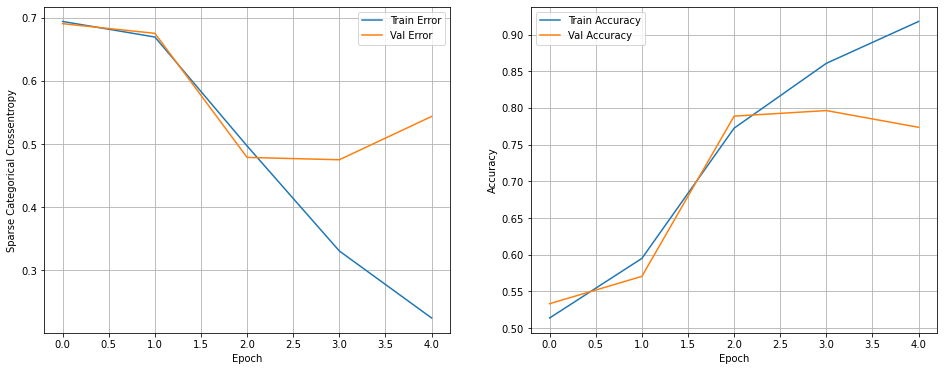

782/782 [==============================] - 66s 84ms/step - loss: 0.5543 - accuracy: 0.7650
Test Loss: 0.5543357133865356
Test Accuracy: 0.7650399804115295


In [18]:
show_loss_accuracy_evolution(history)
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

In [19]:
def show_errors(x_test, model, labels, int2word, n_samples=10):
    preds = 1.0 * (model.predict(x_test).flatten() > 0.5)
    bad_pred_inds = np.where(preds != labels)[0]
    n_samples = min(len(bad_pred_inds), n_samples)
    samples_inds = np.random.choice(bad_pred_inds, n_samples)
    for ind in samples_inds:
        print('Predicted : {0}, real : {1}, lenght: {2}'.format(
            int(preds[ind]), labels[ind], len(test_data[ind])))
        print(get_words(test_data[ind], int2word))
        print()
    return

show_errors(x_test_seq, model, test_labels, int2word, n_samples=10)

Predicted : 1, real : 0, lenght: 270
<START> black <UNK> did this plot so much better which is why it is <UNK> and the man with two lives is just a forgotten <UNK> <UNK> no tears was it's working title and it would have been a better one as he was a thoroughly evil character for most of the film br br <UNK> <UNK> is <UNK> <UNK> when he is involved in a <UNK> accident dr <UNK> <UNK> <UNK> has been involved in some <UNK> <UNK> on animals <UNK> them back from the dead his <UNK> <UNK> him to try his <UNK> on <UNK> who has died as he is <UNK> a dangerous criminal <UNK> is going to the <UNK> <UNK> and <UNK> <UNK> of the soul <UNK> when <UNK> <UNK> from the <UNK> he has the soul of he is a changed person he is <UNK> to his family and starts to <UNK> around old <UNK> he takes over <UNK> old gang going by the name of <UNK> <UNK> he also <UNK> <UNK> former girlfriend who <UNK> a <UNK> <UNK> as <UNK> is <UNK> to even up <UNK> and starts to <UNK> his <UNK> <UNK> <UNK> up including the girlfriend a

#### Making predictioins with new data

In [20]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
           'the film is not good',
           'the film is not bad',
          'the movie is not bad I like it']
sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

## Padding the sequences
x_pred  = sequence.pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')# ...

np.round(model.predict(x_pred), 4)

array([[0.0362],
       [0.9702],
       [0.9599],
       [0.9103],
       [0.0244],
       [0.0533]], dtype=float32)

In [21]:
1.0*(model.predict(x_pred) > 0.5)

array([[0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.]])

### GRU model
Use `keras.layers.GRU`


In [22]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))

## complete the model with recurrent layers
model.add(layers.GRU(64, return_sequences=False))
## add binary classification output
model.add(layers.Dense(1, activation='sigmoid'))

In [24]:
## set the loss and see the results
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

Epoch 1/5
88/88 [==============================] - 120s 1s/step - loss: 0.6858 - accuracy: 0.5392 - val_loss: 0.4927 - val_accuracy: 0.7700
Epoch 2/5
88/88 [==============================] - 143s 2s/step - loss: 0.4447 - accuracy: 0.7963 - val_loss: 0.4134 - val_accuracy: 0.8176
Epoch 3/5
88/88 [==============================] - 176s 2s/step - loss: 0.3699 - accuracy: 0.8373 - val_loss: 0.4056 - val_accuracy: 0.8188
Epoch 4/5
88/88 [==============================] - 150s 2s/step - loss: 0.3543 - accuracy: 0.8443 - val_loss: 0.4053 - val_accuracy: 0.8144
Epoch 5/5
88/88 [==============================] - 171s 2s/step - loss: 0.3400 - accuracy: 0.8526 - val_loss: 0.4419 - val_accuracy: 0.8000


In [25]:
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 [==============================] - 95s 121ms/step - loss: 0.4489 - accuracy: 0.7922
Test Loss: 0.4488656520843506
Test Accuracy: 0.7922000288963318


### LSTM model
Use `keras.layers.LSTM` 


In [26]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))

## complete the model with recurrent layers
model.add(layers.LSTM(64, return_sequences=False))
## add binary classification output
model.add(layers.Dense(1, activation='sigmoid'))

In [27]:
## set the loss and see the results
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

Epoch 1/5
88/88 [==============================] - 216s 2s/step - loss: 0.6599 - accuracy: 0.5767 - val_loss: 0.4748 - val_accuracy: 0.8012
Epoch 2/5
88/88 [==============================] - 185s 2s/step - loss: 0.4313 - accuracy: 0.8116 - val_loss: 0.4212 - val_accuracy: 0.8040
Epoch 3/5
88/88 [==============================] - 88s 1s/step - loss: 0.3778 - accuracy: 0.8341 - val_loss: 0.4187 - val_accuracy: 0.8096
Epoch 4/5
88/88 [==============================] - 82s 935ms/step - loss: 0.3621 - accuracy: 0.8424 - val_loss: 0.4038 - val_accuracy: 0.8116
Epoch 5/5
88/88 [==============================] - 81s 917ms/step - loss: 0.3493 - accuracy: 0.8460 - val_loss: 0.4193 - val_accuracy: 0.8080


In [28]:
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 [==============================] - 59s 75ms/step - loss: 0.4325 - accuracy: 0.8034
Test Loss: 0.4325280785560608
Test Accuracy: 0.8034399747848511


### Deep model
Use `keras.layers.SimpleRNN`,  `keras.layers.GRU`,  `keras.layers.LSTM` or `keras.layers.Bidirectional`


In [29]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))

## complete the model with recurrent layers
model.add(layers.GRU(64, return_sequences=True))
model.add(layers.GRU(64, return_sequences=False))
## add binary classification output
model.add(layers.Dense(1, activation='sigmoid'))

In [30]:
## set the loss and see the results
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

Epoch 1/5
88/88 [==============================] - 85s 928ms/step - loss: 0.6782 - accuracy: 0.5493 - val_loss: 0.4938 - val_accuracy: 0.7564
Epoch 2/5
88/88 [==============================] - 91s 1s/step - loss: 0.4343 - accuracy: 0.8010 - val_loss: 0.4194 - val_accuracy: 0.8108
Epoch 3/5
88/88 [==============================] - 103s 1s/step - loss: 0.3785 - accuracy: 0.8344 - val_loss: 0.4170 - val_accuracy: 0.8136
Epoch 4/5
88/88 [==============================] - 114s 1s/step - loss: 0.3590 - accuracy: 0.8448 - val_loss: 0.4158 - val_accuracy: 0.8132
Epoch 5/5
88/88 [==============================] - 164s 2s/step - loss: 0.3470 - accuracy: 0.8491 - val_loss: 0.4234 - val_accuracy: 0.8152


In [31]:
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 [==============================] - 114s 146ms/step - loss: 0.4352 - accuracy: 0.8050
Test Loss: 0.4352430999279022
Test Accuracy: 0.8049600124359131


### Bidirectional model
Use `keras.layers.SimpleRNN`,  `keras.layers.GRU`,  `keras.layers.LSTM` with `keras.layers.Bidirectional`


In [32]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))

## complete the model with recurrent layers
model.add(layers.Bidirectional(layers.GRU(64, return_sequences=False)))
model.add(layers.Dense(1, activation='sigmoid'))

In [34]:
## set the loss and see the results
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

Epoch 1/5
88/88 [==============================] - 386s 4s/step - loss: 0.6766 - accuracy: 0.5540 - val_loss: 0.4971 - val_accuracy: 0.7696
Epoch 2/5
88/88 [==============================] - 172s 2s/step - loss: 0.4369 - accuracy: 0.8002 - val_loss: 0.4155 - val_accuracy: 0.8108
Epoch 3/5
88/88 [==============================] - 153s 2s/step - loss: 0.3608 - accuracy: 0.8414 - val_loss: 0.4223 - val_accuracy: 0.8060
Epoch 4/5
88/88 [==============================] - 183s 2s/step - loss: 0.3441 - accuracy: 0.8553 - val_loss: 0.4239 - val_accuracy: 0.8140
Epoch 5/5
88/88 [==============================] - 188s 2s/step - loss: 0.3139 - accuracy: 0.8677 - val_loss: 0.4388 - val_accuracy: 0.8072


In [35]:
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 [==============================] - 120s 154ms/step - loss: 0.4523 - accuracy: 0.7944
Test Loss: 0.4523336589336395
Test Accuracy: 0.794439971446991


#### Making predictioins with new data

In [36]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
           'the film is not good',
           'the film is not bad',
           'the movie is not bad I like it']
sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

## Padding the sequences
x_pred  = sequence.pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')# ...

np.round(model.predict(x_pred), 4)

array([[0.2854],
       [0.9668],
       [0.8511],
       [0.7447],
       [0.5015],
       [0.5001]], dtype=float32)

In [37]:
show_errors(x_test_seq, model, test_labels, int2word, n_samples=10)

Predicted : 1, real : 0, lenght: 166
<START> i just <UNK> watching <UNK> <UNK> that i <UNK> from my <UNK> i <UNK> it <UNK> from years ago and wanted to watch it with my son anyway the movie was less than 2 hours running time and i thought it was much longer when i first saw it the back of the vhs box states that the <UNK> a <UNK> <UNK> whose <UNK> could <UNK> the free world forever the <UNK> were supposedly on a <UNK> mission to <UNK> the <UNK> <UNK> there was nothing even <UNK> about <UNK> this <UNK> also the box says that the <UNK> <UNK> <UNK> <UNK> <UNK> on human blood that would make this a horror movie and there was also nothing <UNK> in the movie about this i can't remember the details when i watched this years ago on tv but could the back of this box actually be true maybe the 3 hour movie <UNK> more details br br just wondering if anyone knows anything about this

Predicted : 1, real : 0, lenght: 176
<START> my mother forced me to watch this movie with her she apparently will w

###  Use a convolutional network instead of a RNN

```python
tf.keras.layers.Conv1D(
    filters, kernel_size
)
```

```python
tf.keras.layers.MaxPool1D(
    pool_size=2
)
```

```python
tf.keras.layers.Flatten()
```

In [42]:
from tensorflow.keras.datasets import imdb
num_words = 2000
((train_data, train_labels), (test_data, test_labels)
 ) = imdb.load_data(num_words=num_words)

#  limit the data for class time
# Transform word_id to word and reverse
word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3

In [43]:
max_len = 100
x_train_seq = sequence.pad_sequences(train_data, maxlen=max_len, truncating='post', padding='post')
x_test_seq = sequence.pad_sequences(test_data, maxlen=max_len, truncating='post', padding='post')

print('train shape:', x_train_seq.shape)
print('test shape:', x_test_seq.shape)

train shape: (25000, 100)
test shape: (25000, 100)


In [44]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))


model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))

model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))

model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [45]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

Epoch 1/5
88/88 [==============================] - 74s 831ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6747 - val_accuracy: 0.6352
Epoch 2/5
88/88 [==============================] - 70s 793ms/step - loss: 0.6032 - accuracy: 0.6811 - val_loss: 0.4481 - val_accuracy: 0.7912
Epoch 3/5
88/88 [==============================] - 50s 570ms/step - loss: 0.3984 - accuracy: 0.8220 - val_loss: 0.4070 - val_accuracy: 0.8140
Epoch 4/5
88/88 [==============================] - 49s 558ms/step - loss: 0.3549 - accuracy: 0.8434 - val_loss: 0.3995 - val_accuracy: 0.8192
Epoch 5/5
88/88 [==============================] - 50s 571ms/step - loss: 0.3104 - accuracy: 0.8689 - val_loss: 0.4124 - val_accuracy: 0.8100


In [46]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
           'the film is not good',
           'the film is not bad']
sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

## Padding the sequences
x_pred  = sequence.pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')# ...

np.round(model.predict(x_pred), 4)

array([[0.3799],
       [0.9474],
       [0.8705],
       [0.7794],
       [0.6296]], dtype=float32)

In [47]:
show_errors(x_test_seq, model, test_labels, int2word, n_samples=10)

Predicted : 0, real : 1, lenght: 213
<START> <UNK> director david <UNK> <UNK> love of blood and gore and <UNK> heads with the more confusing aspects of a reality <UNK> david <UNK> film and it actually works <UNK> i won't bother trying to give even the <UNK> <UNK> of a plot <UNK> here because <UNK> only cause more <UNK> all you need to know is that the film is about a <UNK> reality computer game that is so incredibly <UNK> that it becomes difficult to tell the difference between reality and <UNK> reality the film almost seems to <UNK> its <UNK> <UNK> point at the end but then it <UNK> in the final twist in the very last line of dialogue br br there's also some very <UNK> sexual <UNK> based around the in the <UNK> <UNK> as well as some very <UNK> acting from <UNK> law he manages to come off as <UNK> and stupid and boring and any other annoying <UNK> you can care to think of jason <UNK> <UNK> comes off much better and everyone else can be called a supporting character including <UNK> <UNK